Check out Kaggle at https://www.kaggle.com/c/conways-reverse-game-of-life-2020. The objective is to reverse Conway's Game of Life Board (25x25 cells) to learn its position $\delta$ steps ago ($1<=\delta<=5$). We experiment with Convolvers, CNN Encoder-Decoders, and Generative Adverserial Networks, while evaluating performance on custom decaying losses (MSE/Brier, Entropy, Hinge) as well as ROC.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import gc
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.layers import Dropout, GaussianNoise, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import sklearn.model_selection
from copy import deepcopy
import sklearn.metrics

<h2> Data Preprocessing </h2>

In [2]:
start = time.time()
data = pd.read_csv("./train.csv")
X1 = data[data.columns[np.vectorize(lambda s: "start" in s)(data.columns.values)]]
X1 = X1.values.reshape(data.shape[0],25,25,1)
delta = data["delta"].values
X2 = np.zeros((data.shape[0],25*25*5))
for i in range(data.shape[0]):
    X2[i,(delta[i]-1)::5] = 1
temp = data[data.columns[np.vectorize(lambda s: "stop" in s)(data.columns.values)]].values
Y = np.zeros((data.shape[0],25*25*5))
for i in range(data.shape[0]):
    Y[i,(delta[i]-1)::5] = temp[i]
print("Preprocessing Exited in "+str(time.time()-start)+" seconds")
data.shape, X1.shape, X2.shape, Y.shape

Preprocessing Exited in 8.668911933898926 seconds


((50000, 1252), (50000, 25, 25, 1), (50000, 3125), (50000, 3125))

<h2>Approach 1: N-Step Convolver</h2><br/>
We attempt to use a series of convolutions that maintain same padding to move from current Game of Life state to the outputs states. Specifically, we create a weighted_mean_squared_error custom loss function, wrapped inside a call-back and a class that decrements the higher weight to positive class over time.

In [3]:
def build_model(lossfunc="mean_squared_error"):
    tf.keras.backend.clear_session()
    deltainp = Input((25*25*5), dtype=tf.float32) #Delta Mask
    gofinp = Input((25,25,1)) #Game of Life Board
    #Increasing Filters to Capture Relationships
    conv1 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(gofinp)
    max1 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv1)
    conv2 = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max1)
    max2 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv2)
    #Reducing Filters to Final Output
    conv3 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max2)
    max3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv3)
    final = Conv2D(filters=5, kernel_size=(7,7), strides=(1,1), padding="same", activation=None)(max3)
    #Evaluate Required Board
    final = tf.keras.layers.Activation(activation="sigmoid")(Flatten()(final))
    final = Flatten()(tf.math.multiply(final, deltainp))
    model = Model(inputs=[gofinp, deltainp], outputs=final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss=lossfunc)
    return model
build_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 32)   1600        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 25, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 64)   100416      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [4]:
def plotter(model, hist, lossfntitle):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(lossfntitle+" over Time")
    plt.xlabel("Epoch")
    plt.ylabel("Value of Loss Function")
    pd.Series(hist.history["loss"]).plot(label="Train Data")
    pd.Series(hist.history["val_loss"]).plot(label="Validation Data")
    plt.legend(loc="best")
    plt.subplot(1,2,2)
    conf = np.zeros((2,2))
    res = model.predict([X1[40000:],X2[40000:]])
    for i in range(res.shape[0]):
        pred = deepcopy(res[i,(delta[40000+i]-1)::5])
        pred[pred<(2/3)] = 0
        pred[pred>(2/3)] = 1
        corr = Y[40000+i,(delta[40000+i]-1)::5]
        for i in range(2):
            for j in range(2):
                conf[i,j] += np.sum((corr==j)&(pred==i))
    ax = sns.heatmap(conf/np.sum(conf, axis=0).reshape(1,-1)*100, annot=True, cmap="Blues", fmt=".1f")
    for t in ax.texts: t.set_text(t.get_text() + "%")
    plt.xlabel("Real Cell Label")
    plt.ylabel("Predicted Cell Label")
    plt.title("Confusion Matrix at Cut-off of 2/3")
    plt.show()

In [5]:
class WeightedMSE:
    def __init__(self, origweight, targetweight, decayepoch):
        self.weight = origweight
        self.decay = (origweight-targetweight)/(decayepoch-1)
        self.endepoch = decayepoch
    def loss(self, ytrue, ypred):
        diff = ytrue-ypred
        poserr = tf.map_fn(lambda s: tf.reduce_sum(tf.math.square(s[s>0])), diff)*self.weight
        negerr = tf.map_fn(lambda s: tf.reduce_sum(tf.math.square(s[s<0])), diff)
        return tf.reduce_mean(poserr)+tf.reduce_mean(negerr)
    def update_weight(self, epoch):
        if (epoch<self.endepoch) and (epoch!=0):
            self.weight-=self.decay
class LossCallBack(keras.callbacks.Callback):
    def __init__(self, lossclass):
        self.lossclass = lossclass
    def on_epoch_end(self, epoch, logs):
        self.lossclass.update_weight(epoch)

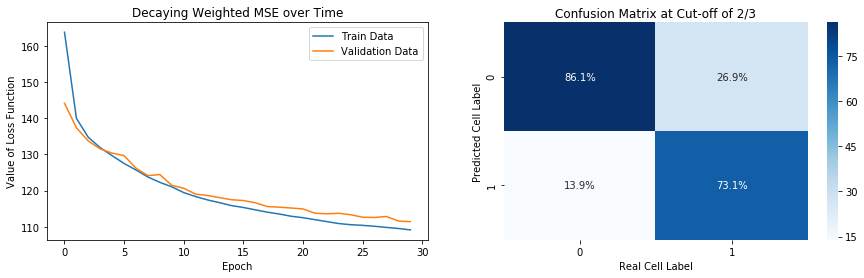

In [6]:
#Visualizing Results on First Fold
numepochs, decayepochs = 30, 22
lossclass = WeightedMSE(5, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model1 = build_model(lossclass.loss)
hist = model1.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])
model1.save("./model1MSE.h5")
plotter(model1, hist, "Decaying Weighted MSE")

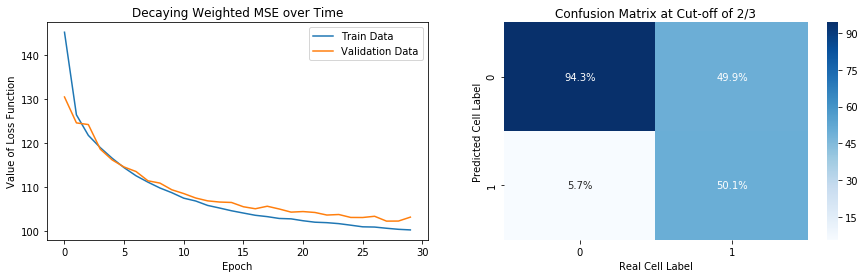

In [7]:
#Visualizing Results on First Fold - New Decay
numepochs, decayepochs = 30, 20
lossclass = WeightedMSE(4, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model2 = build_model(lossclass.loss)
hist = model2.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])  
model2.save("./model2MSE.h5")
plotter(model2, hist, "Decaying Weighted MSE")

In [6]:
#Modified version of categorical cross-entropy to capture imbalance
class LogEntropy:
    def __init__(self, origweight, targetweight, decayepoch):
        self.weight = origweight
        self.decay = (origweight-targetweight)/(decayepoch-1)
        self.endepoch = decayepoch
    def loss(self, ytrue, ypred):
        newten = tf.where(ytrue==0, 1-ypred, ypred)
        newten = tf.where(ytrue==1, tf.math.log(newten)*self.weight, tf.math.log(newten))
        err = tf.map_fn(lambda s: tf.reduce_sum(s), newten)
        return -tf.reduce_mean(err)
    def update_weight(self, epoch):
        if (epoch<self.endepoch) and (epoch!=0):
            self.weight-=self.decay

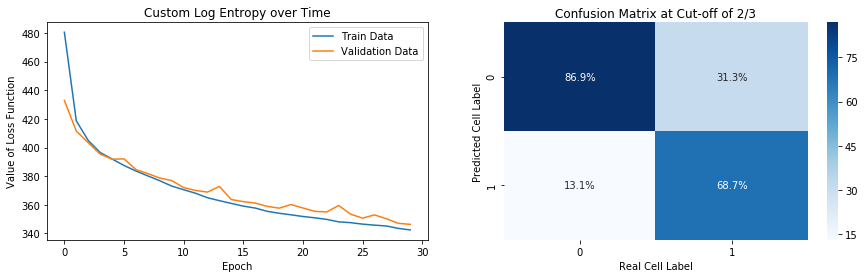

In [9]:
numepochs, decayepochs = 30,22
lossclass = LogEntropy(5, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model3 = build_model(lossclass.loss)
hist = model3.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])
model3.save("./model3Entropy.h5")
plotter(model3, hist, "Custom Log Entropy")

In [7]:
#Weighted Hinge Losses over Time
class WeightedHinge:
    def __init__(self, origweight, targetweight, decayepoch, norm):
        self.weight = origweight
        self.decay = (origweight-targetweight)/(decayepoch-1)
        self.endepoch = decayepoch
        self.power = norm
    def loss(self, ytrue, ypred):
        newten = (1-tf.where(ytrue==0, -1.0, 1.0)*ypred)**self.power-1
        newten = tf.where(ytrue==1, newten*self.weight, newten)
        value = tf.reduce_mean(tf.reduce_sum(newten, axis=1))
        return value
    def update_weight(self, epoch):
        if (epoch<self.endepoch) and (epoch!=0):
            self.weight-=self.decay

<h2> Approach 2: CNN-Encoder-Decoder </h2>

In [8]:
def build_encdec(lossfunc="mean_squared_error", lr=2e-3):
    tf.keras.backend.clear_session()
    deltainp = Input((25*25*5), dtype=tf.float32) #Delta Mask
    gofinp = Input((25,25,1)) #Game of Life Board
    #Encoder Design
    conv1 = Conv2D(filters=16, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(gofinp)
    max1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv1)
    conv2 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max1)
    max2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
    conv3 = Conv2D(filters=128, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max2)
    #Decoder Design
    dec1 = Conv2DTranspose(filters=32, strides=(1,1), kernel_size=(7,7), padding="same", activation="relu")(conv3)
    up2 = UpSampling2D(size=(2,2), interpolation="nearest")(dec1)
    #Skip Connections for Efficient Information Transfer
    up2_2 = Concatenate()([up2, conv2])
    dec2 = Conv2DTranspose(filters=24, strides=(1,1), kernel_size=(7,7), padding="same", activation="relu")(up2_2)
    up3 = UpSampling2D(size=(2,2), interpolation="nearest")(dec2)
    dec3 = Conv2DTranspose(filters=5, strides=(1,1), kernel_size=(2,2), activation=None)(up3)
    #Evaluate Required Board
    final = tf.keras.layers.Activation(activation="sigmoid")(Flatten()(dec3))
    final = tf.math.multiply(final, deltainp)
    model = Model(inputs=[gofinp, deltainp], outputs=final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=lossfunc)
    return model
build_encdec().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 16)   800         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   25120       max_pooling2d[0][0]              
______________________________________________________________________________________________

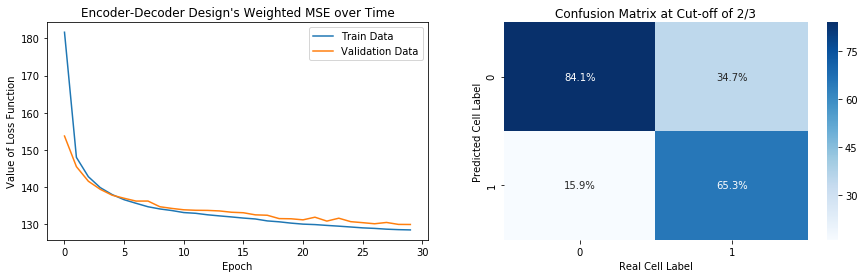

In [20]:
#Visualizing Results on First Fold
numepochs, decayepochs = 30,20
lossclass = WeightedMSE(5, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model4 = build_encdec(lossfunc=lossclass.loss, lr=3e-3)
hist = model4.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])
model4.save("./model4MSEencoder.h5")
plotter(model4, hist, "Encoder-Decoder Design's Weighted MSE")

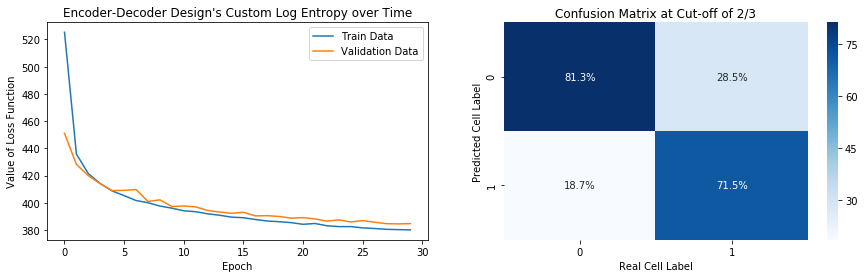

In [23]:
#Visualizing Results on First Fold - Log Entropy
numepochs, decayepochs = 30,22
lossclass = LogEntropy(5, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model5 = build_encdec(lossfunc=lossclass.loss, lr=3e-3)
hist = model5.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])
model5.save("./model5Entropyencoder.h5")
plotter(model5, hist, "Encoder-Decoder Design's Custom Log Entropy")

In [22]:
#ROC-AUC Analysis
model1, model2, model3 = build_model(), build_model(), build_model()
model1.load_weights("./model1MSE.h5")
model2.load_weights("./model2MSE.h5")
model3.load_weights("./model3Entropy.h5")
model4, model5 = build_encdec(), build_encdec()
model4.load_weights("./model4MSEEncoder.h5")
model5.load_weights("./model5EntropyEncoder.h5")
models = [model1, model2, model3, model4, model5]
types = ["N-Step Convolver, MSE/Brier-1", "N-Step Convolver, MSE/Brier-2", "N-Step Convolver, Custom Entropy",
        "Encoder-Decoder, MSE/Brier", "Encoder-Decoder, Custom Entropy"]
truthdeque, scoredeque = collections.deque(), collections.deque()
for model in models:
    res = model.predict([X1[40000:],X2[40000:]])
    truth, score = np.zeros(10000*625), np.zeros(10000*625)
    for i in range(res.shape[0]):
        truth[(i*625):((i+1)*625)] = Y[40000+i,(delta[40000+i]-1)::5]
        score[(i*625):((i+1)*625)] = res[i,(delta[40000+i]-1)::5]
    truthdeque.append(truth)
    scoredeque.append(score)
len(truthdeque), truthdeque[0].shape, len(scoredeque), scoredeque[0].shape

(5, (6250000,), 5, (6250000,))

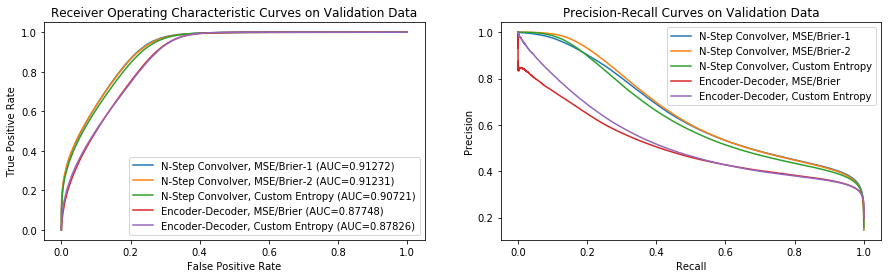

In [35]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
for i in range(len(models)):
    fpr, tpr, _ = sklearn.metrics.roc_curve(truthdeque[i], scoredeque[i])
    scr = sklearn.metrics.roc_auc_score(truthdeque[i], scoredeque[i], average="weighted")
    pd.Series(tpr[::10], index=fpr[::10]).plot(label=types[i]+" (AUC="+str(round(scr,5))+")")
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curves on Validation Data")
plt.subplot(1,2,2)
for i in range(len(models)):
    prec, rec, _ = sklearn.metrics.precision_recall_curve(truthdeque[i], scoredeque[i])
    pd.Series(prec[::10], index=rec[::10]).plot(label=types[i])
plt.legend(loc="best")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves on Validation Data")
plt.show()

<h2> Approach 3: Generative Adverserial Networks